## Libraries

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.layers import GlobalAveragePooling1D, Concatenate, Dropout, Dense, Input
from transformers import *

## Display data

In [2]:
train_df = pd.read_csv("./input/train.csv")
test_df = pd.read_csv("./input/test.csv")

labels_list = list(train_df.columns[11:])
input_columns_list = list(train_df.columns[[1, 2, 5]])

print(f"List of possible labels: \n {labels_list} \n")
print(f"Input columns: \n {input_columns_list}")

List of possible labels: 
 ['question_asker_intent_understanding', 'question_body_critical', 'question_conversational', 'question_expect_short_answer', 'question_fact_seeking', 'question_has_commonly_accepted_answer', 'question_interestingness_others', 'question_interestingness_self', 'question_multi_intent', 'question_not_really_a_question', 'question_opinion_seeking', 'question_type_choice', 'question_type_compare', 'question_type_consequence', 'question_type_definition', 'question_type_entity', 'question_type_instructions', 'question_type_procedure', 'question_type_reason_explanation', 'question_type_spelling', 'question_well_written', 'answer_helpful', 'answer_level_of_information', 'answer_plausible', 'answer_relevance', 'answer_satisfaction', 'answer_type_instructions', 'answer_type_procedure', 'answer_type_reason_explanation', 'answer_well_written'] 

Input columns: 
 ['question_title', 'question_body', 'answer']


In [4]:
train_df[input_columns_list + labels_list].head()

,question_title,question_body,answer,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,What am I losing when using extension tubes in...,After playing around with macro photography on...,"I just got extension tubes, so here's the skin...",1.000000,0.333333,0.000000,0.0,0.0,0.0,1.000000,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,0.000000,1.000000
1,What is the distinction between a city and a s...,I am trying to understand what kinds of places...,It might be helpful to look into the definitio...,1.000000,1.000000,0.000000,0.5,1.0,1.0,0.444444,...,0.888889,0.888889,0.555556,0.888889,0.888889,0.666667,0.0,0.000000,0.666667,0.888889
2,Maximum protusion length for through-hole comp...,I'm working on a PCB that has through-hole com...,Do you even need grooves? We make several pro...,0.888889,0.666667,0.000000,1.0,1.0,1.0,0.666667,...,0.777778,0.777778,0.555556,1.000000,1.000000,0.666667,0.0,0.333333,1.000000,0.888889
3,Can an affidavit be used in Beit Din?,"An affidavit, from what i understand, is basic...","Sending an ""affidavit"" it is a dispute between...",0.888889,0.666667,0.666667,1.0,1.0,1.0,0.444444,...,0.888889,0.833333,0.333333,0.833333,1.000000,0.800000,0.0,0.000000,1.000000,1.000000
4,How do you make a binary image in Photoshop?,I am trying to make a binary image. I want mor...,Check out Image Trace in Adobe Illustrator. \n...,1.000000,0.666667,0.000000,1.0,1.0,1.0,0.666667,...,1.000000,1.000000,0.666667,1.000000,1.000000,0.800000,1.0,0.000000,1.000000,1.000000


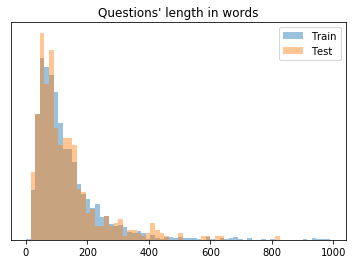

In [5]:
# Title is considered as part of the question
len_q_train = [len(q.split()) for q in train_df["question_title"] + train_df["question_body"]]
len_q_test = [len(q.split()) for q in test_df["question_title"] + test_df["question_body"]]

plt.hist(len_q_train, bins = np.arange(0, 1000, 15), alpha = 0.45, label = "Train", density = True)
plt.hist(len_q_test, bins = np.arange(0, 1000, 15), alpha = 0.45, label = "Test", density = True)
plt.title("Questions' length in words")
plt.yticks([])
plt.legend()
plt.show()

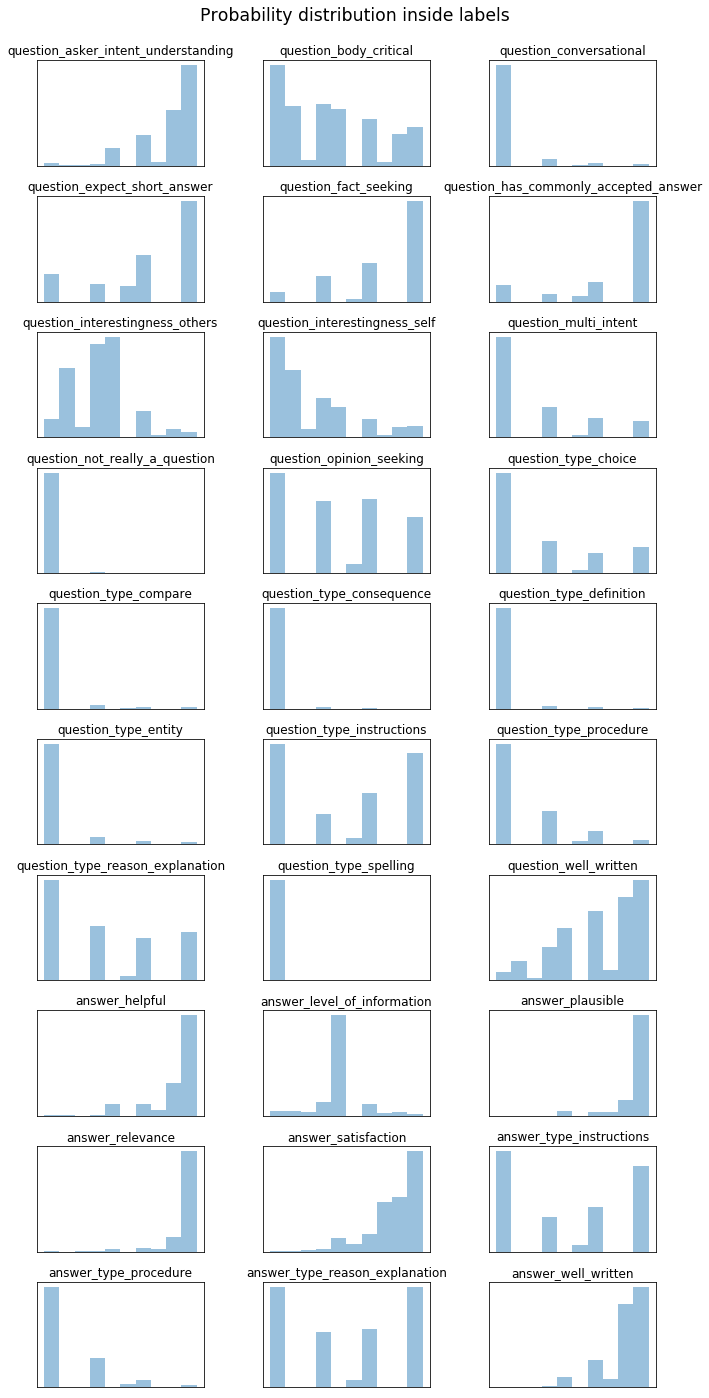

In [6]:
fig = plt.figure(figsize = (10, 19))
for i in range(30):
    plt.subplot(10, 3, i + 1)
    plt.hist(train_df[labels_list[i]], alpha = 0.45)
    plt.title(labels_list[i])
    plt.ylabel("")
    plt.xlabel("")
    plt.xticks([])
    plt.yticks([])
plt.tight_layout()
fig.suptitle("Probability distribution inside labels", y = 1.02, size = "xx-large")
plt.show()

## Preprocess text sequences

In [3]:
MAX_SEQ_LEN = 512

tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [4]:
def clean_string(string):
    """Removes unnecessary characters from string"""
    if string is None:
        return string
    string = string.replace("\\", " ")
    string = string.replace("/", " ")
    string = re.sub("[\][_.,:;!?¿+=–*~#$€£§%&(){}|<>½@©®™^`“”\"\']", "", string)
    return string

def process_string(string, second_string, max_len):
    """Converts a string to ids, masks and token type ids (segment ids)"""
    # Returns a dictionary containing the encoded sequence or sequence pair
    string = clean_string(string)
    second_string = clean_string(second_string)
    encoded = tokenizer.encode_plus(
        text = string,
        text_pair = second_string,
        max_length = max_len,
        add_special_tokens = True, # encode with tokens specific to the model: [PAD], [SEP]...
        pad_to_max_length = True, # pad with zeroes from the right
    )
    # --------- 1. List of token IDs ---------
    # Numerical representation (1, 512) of sequence that consists of tokens (in tokenizer vocabulary)
    ids =  encoded["input_ids"]
    
    # --------- 2. List of attention masks ---------
    # Binary vector (1, 512) indicating the position of the padded indices
    # 1 indicates a value that should be attended to while 0 indicates a padded value
    masks = encoded["attention_mask"]
    
    # --------- 3. List of token type IDs (aka segment ids) ---------
    # Binary vector (1, 512) identifying the different sequences in the model
    # First input string is the context ie title/answer (0) and the second one is the question (1)    
    segments = encoded["token_type_ids"]
    
    # Return 3 x (1, 512) vectors
    return [ids, masks, segments]

def process_row(title, question, answer, max_len):
    """Converts a single (title, question, answer) triplet to ids, masks and segments"""
    # Title is considered as part of the question but seperated by special token from the body
    ids_q, masks_q, segments_q = process_string(title, question, max_len)
    # Answer is processed as is
    ids_a, masks_a, segments_a = process_string(answer, None, max_len)
    # Return the 6 x (1, 512) vectors
    return [ids_q, masks_q, segments_q, ids_a, masks_a, segments_a]

def process_df(df, max_len):
    """Preprocess a whole dataframe ready for a transformer"""
    ids_q_all, masks_q_all, segments_q_all = [], [], []
    ids_a_all, masks_a_all, segments_a_all = [], [], []
    # Iterate over all rows in a dataframe filtered by chosen input columns
    for _, row in df[input_columns_list].iterrows():
        ids_q, masks_q, segments_q, ids_a, masks_a, segments_a = process_row(
            row["question_title"],
            row["question_body"],
            row["answer"],
            max_len
        )
        # Results in 6 x (N, 512) lists
        ids_q_all.append(ids_q)
        masks_q_all.append(masks_q)
        segments_q_all.append(segments_q)
        ids_a_all.append(ids_a)
        masks_a_all.append(masks_a)
        segments_a_all.append(segments_a)
        
    # Return 6 x (N, 512) arrays
    return [np.asarray(ids_q_all, dtype = np.int32), 
            np.asarray(masks_q_all, dtype = np.int32), 
            np.asarray(segments_q_all, dtype = np.int32),
            np.asarray(ids_a_all, dtype = np.int32), 
            np.asarray(masks_a_all, dtype = np.int32), 
            np.asarray(segments_a_all, dtype = np.int32)]

In [5]:
y_train = np.asarray(train_df[labels_list])
x_train = process_df(train_df, MAX_SEQ_LEN)
x_test = process_df(test_df, MAX_SEQ_LEN)

print(f"Shape of training data: {len(x_train)} arrays of shape {x_train[0].shape}")
print(f"Shape of test data: {len(x_test)} arrays of shape {x_test[0].shape}")

Shape of training data: 6 arrays of shape (6079, 512)
Shape of test data: 6 arrays of shape (476, 512)


## Display processed sequences

In [10]:
example_title = train_df.loc[1, "question_title"] 
example_body = train_df.loc[1, "question_body"]
tokenized = process_string(example_title, example_body, MAX_SEQ_LEN)

print("--------- Question in its input format --------- \n")
print(clean_string(example_title + example_body))

print("--------- Question as list of tokens --------- \n")
print(tokenizer.tokenize(clean_string(example_title + example_body)), "\n")

print("--------- Question with special tokens visible --------- \n")
print(tokenizer.decode(tokenized[0], skip_special_tokens = False), "\n")

print("--------- Question as token IDs --------- \n")
print(tokenized[0], "\n")

print("--------- Question's Attention mask --------- \n")
print(tokenized[1], "\n")

print("--------- Question's token type IDs (segment ids) --------- \n")
print(tokenized[2], "\n")

--------- Question in its input format --------- 

What is the distinction between a city and a sprawl metroplex between downtown and a commercial districtI am trying to understand what kinds of places the spam values on p 231 refer to in the 5th Edition main book for Shadowrun

Per p 15 a sprawl is a plex a plex is a metropolitan complex short for metroplex Per Google a metroplex is  a very large metropolitan area especially one that is an aggregation of two or more cities  A city downtown and sprawl downtown would tend to have similar densities but for some reason the sprawl which includes suburbs has a higher spam zone noise rating p 231  Similarly Id think of a downtown as being more dense and noisy eg Office buildings and street vendors than a commercial district eg an outdoor mall  The noise ratings make me think that I am thinking about this incorrectly What is a better way of thinking of them

--------- Question as list of tokens --------- 

['what', 'is', 'the', 'distinction',

## Specify model

In [6]:
config = BertConfig()

# Trained on lower-cased text. 12 layers, 768 hidden units, 12 heads. 30 522 token vocabulary.
bert_model = TFBertModel.from_pretrained("./input/bert-base-uncased-tf_model.h5", config = config)

# Question input: 3 x (n, 512)
q_id = Input((MAX_SEQ_LEN,), dtype = tf.int32)
q_mask = Input((MAX_SEQ_LEN,), dtype = tf.int32)
q_segm = Input((MAX_SEQ_LEN,), dtype = tf.int32)

# Answer input: 3 x (n, 512)
a_id = Input((MAX_SEQ_LEN,), dtype = tf.int32)
a_mask = Input((MAX_SEQ_LEN,), dtype = tf.int32)
a_segm = Input((MAX_SEQ_LEN,), dtype = tf.int32)

# Tansformer outputs hidden state vectors of shape (n, 512, 768) ie (1, hidden_units)
# vector for each token. We only select the hidden state associated with the [CLS] token
# which corresponds to the aggregated sequence representation for classification tasks
q_hidden_states = bert_model(q_id, attention_mask = q_mask, token_type_ids = q_segm)[0][:, 0, :]
a_hidden_states = bert_model(a_id, attention_mask = a_mask, token_type_ids = a_segm)[0][:, 0, :]

# Concatenate into (n, 1536) and classify with dense layer. Output 0...1 for each label
x = Concatenate()([q_hidden_states, a_hidden_states])
x = Dropout(0.2)(x)
x = Dense(30, activation = "sigmoid")(x)

model = Model(
    inputs = [q_id, q_mask, q_segm, a_id, a_mask, a_segm],
    outputs = x
) 

model.compile(
    loss = "binary_crossentropy",
    optimizer = Nadam(lr = 2e-5, beta_1 = 0.9, beta_2 = 0.999),
    metrics = ["acc"]
)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 512)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 512)]        0                                            
______________________________________________________________________________________________

## Fit model

In [7]:
fit_log = model.fit(
    x_train,
    y_train,
    epochs = 3,
    batch_size = 2,
    validation_split = 0.10,
    shuffle = True,
)

model.save_weights("model.h5")

Train on 5471 samples, validate on 608 samples
Epoch 1/4
5471/5471 [==============================] - 1092s 200ms/sample - loss: 0.3928 - acc: 0.5717 - val_loss: 0.3738 - val_acc: 0.5776
Epoch 2/4
5471/5471 [==============================] - 1058s 193ms/sample - loss: 0.3660 - acc: 0.5825 - val_loss: 0.3686 - val_acc: 0.5812
Epoch 3/4
5471/5471 [==============================] - 1067s 195ms/sample - loss: 0.3526 - acc: 0.5879 - val_loss: 0.3676 - val_acc: 0.5832


## Prediction

In [8]:
preds = model.predict(x_test, batch_size = 2)

test_df = pd.read_csv("./input/sample_submission.csv")
test_df[labels_list] = preds
test_df.to_csv("./output/submission.csv", index = False)

test_df.head()

,qa_id,question_asker_intent_understanding,question_body_critical,question_conversational,question_expect_short_answer,question_fact_seeking,question_has_commonly_accepted_answer,question_interestingness_others,question_interestingness_self,question_multi_intent,...,question_well_written,answer_helpful,answer_level_of_information,answer_plausible,answer_relevance,answer_satisfaction,answer_type_instructions,answer_type_procedure,answer_type_reason_explanation,answer_well_written
0,39,0.948825,0.708624,0.194945,0.519537,0.785633,0.707474,0.689952,0.672426,0.870837,...,0.918106,0.900587,0.550924,0.957935,0.947635,0.848217,0.021685,0.034164,0.890482,0.860254
1,46,0.896359,0.571254,0.007727,0.768658,0.816911,0.898187,0.611569,0.452030,0.410623,...,0.756871,0.930465,0.616366,0.965982,0.961041,0.849065,0.865053,0.181224,0.083519,0.847436
2,70,0.915079,0.720179,0.011138,0.867017,0.918891,0.972320,0.608078,0.546771,0.377610,...,0.863369,0.951090,0.516636,0.966736,0.971191,0.831681,0.055756,0.105858,0.943768,0.862718
3,132,0.889225,0.439532,0.005785,0.636978,0.778792,0.929807,0.488031,0.419724,0.184343,...,0.726652,0.933834,0.681995,0.963363,0.972104,0.831208,0.831545,0.289139,0.577163,0.881477
4,200,0.950801,0.476298,0.022709,0.730243,0.831687,0.891894,0.567551,0.579721,0.121068,...,0.638192,0.868146,0.662316,0.967299,0.928248,0.841059,0.198647,0.218649,0.517216,0.904643
